In [400]:
#libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split


In [401]:
#data load
training_set = pd.read_csv("C:/Users/Filip/Desktop/kbc/training_set.csv")
test_set = pd.read_csv("C:/Users/Filip/Desktop/kbc/test_set.csv")

test_set_client_IDs = test_set.Client



In [402]:
training_set.drop(['Client', 'Unnamed: 0' ], axis=1, inplace=True)
test_set.drop(['Client', 'Unnamed: 0' ], axis=1, inplace=True)

In [403]:
#preparing relevant data for models of CL sales and revenues

training_set_CL_sale = training_set.drop(['Sale_MF', 'Sale_CC', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'], axis=1)
test_set_CL_sale = test_set.drop(['Sale_MF', 'Sale_CC', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'], axis=1)

#many 0 values in revenues, lets consider only clients making many as thats our aim


training_set_CL_revenue = training_set.loc[(training_set['Revenue_CL']>0)]

training_set_CL_revenue = training_set_CL_revenue.drop(['Sale_MF', 'Sale_CC', 'Sale_CL','Revenue_MF', 'Revenue_CC'], axis=1)
test_set_CL_revenue = test_set.drop(['Sale_MF', 'Sale_CC', 'Sale_CL','Revenue_MF', 'Revenue_CC'], axis=1)

In [404]:
#CL model - SALES

In [405]:
#stratified sampling to obtain validation set to see performances

def splitting(train_dataset, test_dataset, target_variable):
    
    '''
    Description:
    Function to split datasets for CLASSIFICATION models via Stratified sampling to keep distributions
    
    Purpose: 
    To split datasets and obtain 3 parts - to train model, to evaluate model
    and to make final predictions
    
    Inputs:
    train_dataset - data that were saved as training data, containing details about Sales and Revenues
    test_dataset - data to make the final predictions on, w/o details about Revenues and Sales
    target_variable - target variable of models
    
    Outputs:
    X_train/Y_train - data to train models (70 pcts.)
    X_valid/Y_valid - data to evaluate model (30 pcts.)
    X_test/Y_test / independent data to make predictions on and set marketing campaign 
    '''
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=40)
    
    for train_index, test_index in split.split(train_dataset, train_dataset[target_variable]):
        train_strat = train_dataset.iloc[train_index]
        test_strat = train_dataset.iloc[test_index]
    
    X_train = train_strat.drop(target_variable, axis=1)
    Y_train = train_strat.loc[:,target_variable]
    X_valid = test_strat.drop(target_variable, axis=1)
    Y_valid = test_strat.loc[:,target_variable]
    X_test = test_dataset.drop(target_variable, axis=1)
    Y_test = test_dataset.loc[:,target_variable]
    
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [406]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test=splitting(training_set_CL_sale, test_set_CL_sale, 'Sale_CL')

In [407]:
#Logistic regression

logistic_reg = LogisticRegression(solver='liblinear', random_state=10)
logistic_reg.fit(X_train, Y_train)

LogisticRegression(random_state=10, solver='liblinear')

In [408]:
#Table of coefficients and log odds

log_results=pd.DataFrame(zip(X_train.columns, np.transpose(logistic_reg.coef_)), columns=['features', 'coef']) 
log_results['odds']=((np.exp(log_results['coef'].astype('float')))-1)*100
log_results.sort_values(by=['odds'], ascending=False)

,features,coef,odds
0,Count_CA,[0.4385688315407732],55.048662
4,Count_CC,[0.18104883997987228],19.847371
1,Count_SA,[0.16884289177991177],18.393412
3,Count_OVD,[0.12070589785337515],12.829303
25,TransactionsDebCash_Card,[0.08218035183277268],8.565159
27,TransactionsDeb_PaymentOrder,[0.049661897158043256],5.091572
26,TransactionsDebCashless_Card,[0.036907254453766615],3.759678
17,TransactionsCred_CA,[0.025442703964217484],2.576913
23,TransactionsDeb,[0.021678790215172924],2.191548
2,Count_MF,[0.014475163136622215],1.458044


In [409]:
#classification report train data

y_pred = logistic_reg.predict(X_train)
print(classification_report(Y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86       455
         1.0       0.76      0.25      0.38       179

    accuracy                           0.77       634
   macro avg       0.76      0.61      0.62       634
weighted avg       0.77      0.77      0.72       634



In [410]:
#classification report validation data

y_pred = logistic_reg.predict(X_valid)
print(classification_report(Y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       196
         1.0       0.53      0.25      0.34        77

    accuracy                           0.73       273
   macro avg       0.64      0.58      0.58       273
weighted avg       0.69      0.73      0.69       273



In [411]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_valid, y_pred)

0.5800092764378478

In [412]:
from sklearn.metrics import brier_score_loss
brier_score_loss(Y_valid, y_pred)

0.27472527472527475

In [413]:
#controling validity of predicted probabilities

from sklearn.calibration import calibration_curve
y_valid_predict_proba = logistic_reg.predict_proba(X_valid)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(Y_valid, y_valid_predict_proba, n_bins=10)

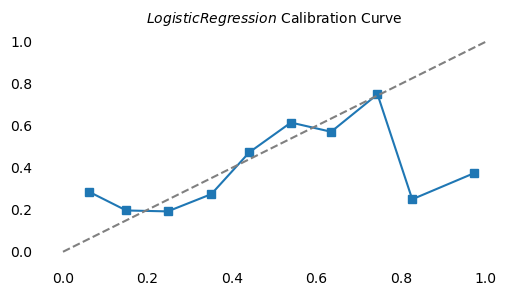

In [414]:
fig, ax = plt.subplots(1, figsize=(6, 3))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$LogisticRegression$ Calibration Curve", fontsize=10); pass

In [415]:
#estimating different cut off values
from sklearn.metrics import precision_score, recall_score, f1_score

for cutoff in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    pred = np.where(logistic_reg.predict_proba(X_valid)[:, 1] > cutoff,1,0)
    print('cutoff',cutoff, 'precision:',precision_score(Y_valid, pred), 'sensitivity:', recall_score(Y_valid, pred), 'f1:', f1_score(Y_valid, pred))
 

cutoff 0.2 precision: 0.30978260869565216 sensitivity: 0.7402597402597403 f1: 0.43678160919540227
cutoff 0.25 precision: 0.3597122302158273 sensitivity: 0.6493506493506493 f1: 0.46296296296296297
cutoff 0.3 precision: 0.39622641509433965 sensitivity: 0.5454545454545454 f1: 0.45901639344262296
cutoff 0.35 precision: 0.4444444444444444 sensitivity: 0.4675324675324675 f1: 0.4556962025316456
cutoff 0.4 precision: 0.509090909090909 sensitivity: 0.36363636363636365 f1: 0.42424242424242425
cutoff 0.45 precision: 0.5581395348837209 sensitivity: 0.3116883116883117 f1: 0.39999999999999997
cutoff 0.5 precision: 0.5277777777777778 sensitivity: 0.24675324675324675 f1: 0.33628318584070793


In [416]:
#predicting probabilities of CL Sale on new data (test)
#checking observations counts in intervals of predicted probabilities

pred_customers = logistic_reg.predict_proba(X_test)[:, 1]

test_set_CL_sale['probabilities_CL']=pred_customers
test_set.groupby(pd.cut(test_set_CL_sale["probabilities_CL"], np.arange(0, 1.1, 0.10))).size()

probabilities_CL
(0.0, 0.1]     74
(0.1, 0.2]    137
(0.2, 0.3]    150
(0.3, 0.4]    112
(0.4, 0.5]     70
(0.5, 0.6]     28
(0.6, 0.7]     14
(0.7, 0.8]      6
(0.8, 0.9]      5
(0.9, 1.0]     10
dtype: int64

In [417]:
#from all customers, selecting only those with prob higher than 30 and lower than 90 perc
'''
Under 30 perc = difficult to convert throught marketing, not really interested in product, good f1 score with 0.3 cutoff
Over 90 perc = not worth to invest resources to target the client via marketing as 
there is high probability they would get the product by themselves
'''
test_set_CL_sale['Client'] = test_set_client_IDs
targeted_clients = test_set_CL_sale.loc[(test_set_CL_sale['probabilities_CL']>0.3) & (test_set_CL_sale['probabilities_CL']<0.9)].copy()

In [418]:
len(targeted_clients)

235

In [419]:
def splitting_regression(train_dataset, test_dataset, target_variable):
    
    '''
    Description:
    Function to split datasets for REGRESSION models
    
    Purpose: 
    To split datasets and obtain 3 parts - to train model, to evaluate model
    and to make final predictions
    
    Inputs:
    train_dataset - data that were saved as training data, containing details about Sales and Revenues
    test_dataset - data to make the final predictions on, w/o details about Revenues and Sales
    target_variable - target variable of models
    
    Outputs:
    X_train/Y_train - data to train models (70 pcts.)
    X_valid/Y_valid - data to evaluate model (30 pcts.)
    X_test/Y_test / independent data to make predictions on and set marketing campaign 
    '''
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(train_dataset.drop(target_variable, axis=1),  train_dataset.loc[:,target_variable], test_size=0.2, random_state=42)
    X_test = test_dataset.drop(target_variable, axis=1)
    Y_test = test_dataset.loc[:,target_variable]
    
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [420]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = splitting_regression(training_set_CL_revenue, test_set_CL_revenue, 'Revenue_CL')

In [421]:
#XGBoost Regression with Randomized parameters search

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [5, 10,15],
           'learning_rate': [0.01, 0.1, 0.2],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            'scale_pos_weight': [1],
           'n_estimators': [100]}
xgbr = xgb.XGBRegressor(seed = 20)
xgb_regression = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring = 'neg_root_mean_squared_error',
                         n_iter=50,
                         verbose=1)

In [422]:
xgb_regression.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50,
                   param_distributions={'colsample_byl

In [423]:
print("Best parameters:", xgb_regression.best_params_)

Best parameters: {'subsample': 0.7999999999999999, 'scale_pos_weight': 1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5}


In [424]:
#Model evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

y_pred = xgb_regression.predict(X_valid)
mae = mean_absolute_error(Y_valid, y_pred)
mse = mean_squared_error(Y_valid, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 5.92
Mean squared error: 54.73
Root mean squared error: 7.40


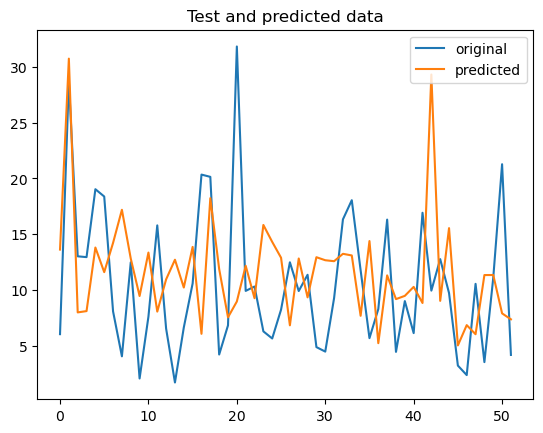

In [425]:
#Actual vs Predicted


x_ax = range(len(Y_valid))
plt.plot(x_ax, Y_valid, label="original")
plt.plot(x_ax, y_pred, label="predicted")

plt.title("Test and predicted data")

plt.legend()
plt.show()

Text(0.5, 0, 'Permutation Importance')

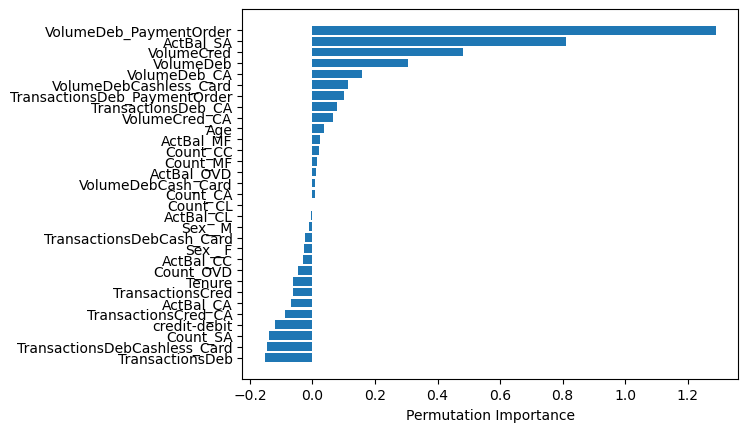

In [426]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(xgb_regression, X_valid, Y_valid, random_state=10, n_repeats=10, scoring = 'neg_root_mean_squared_error')

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns.values[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [427]:
#Predicting Revenue for Targeted Customer
#To note: To train model, only observations with positive revenue were used, as we are aiming for clients that should bring some R
test_set_client_IDs=targeted_clients['Client']
targeted_clients['revenue'] = xgb_regression.predict(targeted_clients.drop(['probabilities_CL', 'Sale_CL', 'Client'], axis=1))
targeted_clients['Client'] = test_set_client_IDs

In [439]:
#Calculation of Expected Revenue as Predicted Revenue * Probability of CL Sale
targeted_clients['expected_revenue'] = targeted_clients['revenue'] * targeted_clients['probabilities_CL']
targeted_clients.reset_index(inplace=True)

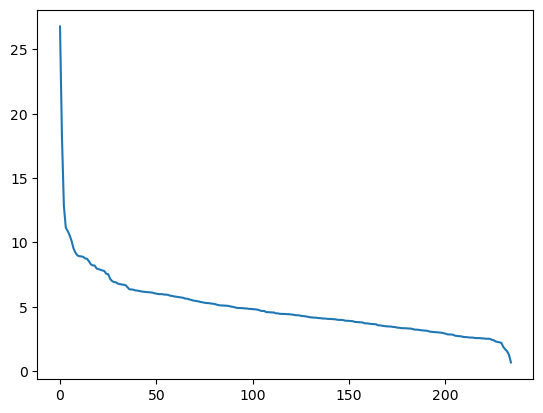

In [440]:
#ER Plot
plt.plot(targeted_clients['expected_revenue'])

In [443]:
#Choosing 100 clients with the highest Expected Revenues
targeted_clients.sort_values(by=['expected_revenue'], inplace=True, ascending=False )
final_dataset_targets = targeted_clients[0:100].copy()
final_dataset_targets.to_csv('targeted_CL.csv')

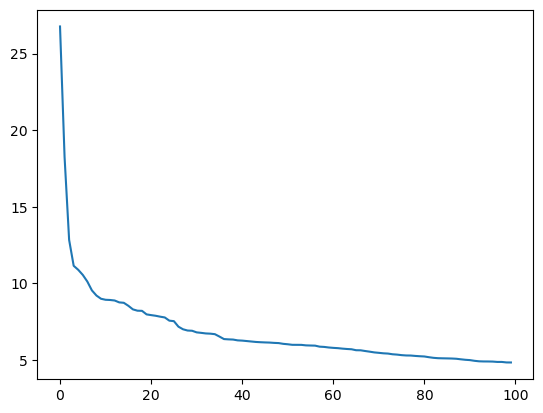

In [444]:
plt.plot(final_dataset_targets['expected_revenue'])

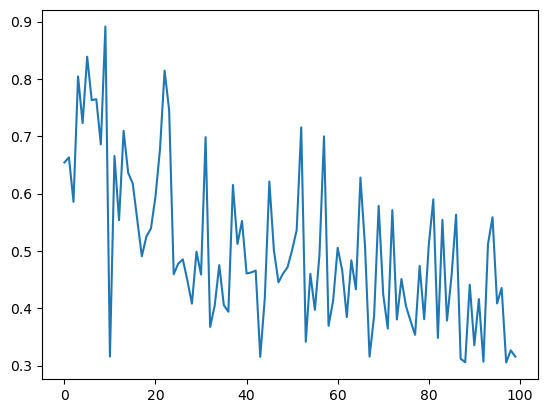

In [445]:
plt.plot(final_dataset_targets['probabilities_CL'])